In [1]:
import requests
import pandas as pd
from config import census_api_key
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
#Grab Data From Census fir the years 2015-2021

In [3]:

# Replace 'YOUR_API_KEY' with your actual Census API key
api_key = census_api_key

# Specify the dataset and variables
dataset = 'acs/acs5'  # American Community Survey 5-Year Estimates
get_vars = 'NAME,B01001_001E'  # Variable for total population (B01001_001E)

# California's FIPS code
for_state = '06'

# Years range from 2015 to 2022
years = range(2015, 2022)

# Create an empty list to store the data
data_list = []

for year in years:
    # Make the API request
    base_url = f'https://api.census.gov/data/{year}/{dataset}?get={get_vars}&for=place:*&in=state:{for_state}&key={api_key}'
    response = requests.get(base_url)

    if response.status_code == 200:
        data = response.json()
        # Add retrieved data to the list
        for entry in data[1:]:  # Skip the header row
            city_name = entry[0]
            population = entry[1]
            data_list.append({'City': city_name, 'Population': population, 'Year': year})
    else:
        print(f"Failed to retrieve data for year {year}.")


In [31]:
# Create a DataFrame from the collected data
population_data = pd.DataFrame(data_list)



population_data['City'] = population_data['City'].str.replace(', California', '')
population_data['City'] = population_data['City'].str.replace(' CDP', '')
population_data['City'] = population_data['City'].str.replace(' city', '')
population_data['City'] = population_data['City'].str.replace(' town', '')

population_data = population_data.groupby(['City', 'Year'])['Population'].sum().reset_index()
population_data = population_data.pivot(index='City', columns='Year', values='Population')

# Display the DataFrame
population_data = population_data.reset_index()


population_data = population_data.rename(columns={
    2015: '2015 Population',
    2016: '2016 Population',
    2017: '2017 Population',
    2018: '2018 Population',
    2019: '2019 Population',
    2020: '2020 Population',
    2021: '2021 Population',
})
population_data['2015 Population'] = population_data['2015 Population'].astype(float)
population_data['2016 Population'] = population_data['2016 Population'].astype(float)
population_data['2017 Population'] = population_data['2017 Population'].astype(float)
population_data['2018 Population'] = population_data['2018 Population'].astype(float)
population_data['2019 Population'] = population_data['2019 Population'].astype(float)
population_data['2020 Population'] = population_data['2020 Population'].astype(float)
population_data['2021 Population'] = population_data['2021 Population'].astype(float)
population_data = population_data.drop(index=174) #huge amount of population 1047255736.0, possibly an error Burbank City
population_data = population_data.drop(index=981) #huge amount of population 779732295.0, possibly an error Mountain View
population_data = population_data.drop(index=446) #huge amount of population 558124418.0, possibly an error El Cerrito
population_data = population_data.drop(index=817) #huge amount of population 180388467.0, possibly an error Live Oak
population_data = population_data.drop(index=583) #huge amount of population 168694347.0, possibly an error Greenfield
population_data = population_data.drop(index=1081) #huge amount of population 26289170.0, possibly an error Paradise
population_data = population_data.drop(index=1221) #huge amount of population 8161820.0, possibly an error Paradise
population_data

Year,City,2015 Population,2016 Population,2017 Population,2018 Population,2019 Population,2020 Population,2021 Population
0,Acalanes Ridge,1139.0,1000.0,894.0,889.0,1134.0,875.0,1074.0
1,Acampo,787.0,466.0,520.0,294.0,204.0,261.0,263.0
2,Acton,7058.0,7170.0,7278.0,7185.0,7232.0,7054.0,6809.0
3,Adelanto,32059.0,32311.0,32867.0,33416.0,33660.0,34238.0,37229.0
4,Adin,173.0,155.0,206.0,201.0,171.0,209.0,171.0
...,...,...,...,...,...,...,...,...
1611,Yreka,7635.0,7598.0,7571.0,7551.0,7562.0,7589.0,7807.0
1612,Yuba City,66038.0,66147.0,66229.0,66388.0,66516.0,66660.0,69540.0
1613,Yucaipa,52739.0,52886.0,53151.0,53264.0,53416.0,54358.0,54312.0
1614,Yucca Valley,21258.0,21362.0,21483.0,21543.0,21622.0,21701.0,21663.0


In [32]:
#population_data['2015 Population'].max()

In [6]:
#test = population_data[population_data['2015 Population'] == 3900794.0]
#test

In [7]:
#Grab data from zillow.csv

In [8]:
zillow_csv = Path("csv_data/clear_ca_sfh1.csv")

In [9]:
zillow_df = pd.read_csv(zillow_csv)
zillow_df = zillow_df.rename(columns={
    '2015': '2015 Price',
    '2016': '2016 Price',
    '2017': '2017 Price',
    '2018': '2018 Price',
    '2019': '2019 Price',
    '2020': '2020 Price',
    '2021': '2021 Price',
})

In [128]:
merge_df = population_data.merge(zillow_df, on='City')
no_nulls_df = merge_df.dropna(how='any')
no_nulls_df = no_nulls_df.drop(index=235) #fairfax, abnormally high % change in population of 234627.2235418316 from 2019-2020
no_nulls_df = no_nulls_df.drop(index=736) #trona, abnornally high % change in population of np.inf from 2015-2016 

no_nulls_df

,City,2015 Population,2016 Population,2017 Population,2018 Population,2019 Population,2020 Population,2021 Population,2015 Price,2016 Price,2017 Price,2018 Price,2019 Price,2020 Price,2021 Price
0,Acampo,787.0,466.0,520.0,294.0,204.0,261.0,263.0,411290.3,457113.1,499479.8,549449.1,576265.3,577935.7,706673.6
1,Acton,7058.0,7170.0,7278.0,7185.0,7232.0,7054.0,6809.0,429758.9,449873.7,483729.3,536849.0,565247.3,591931.2,698957.6
2,Adelanto,32059.0,32311.0,32867.0,33416.0,33660.0,34238.0,37229.0,151547.4,163231.4,185646.1,215282.2,229858.4,245152.2,300593.3
3,Adin,173.0,155.0,206.0,201.0,171.0,209.0,171.0,151136.3,163947.3,175406.9,186325.1,191057.7,193622.4,229474.8
4,Agoura Hills,20697.0,20689.0,20736.0,20636.0,20533.0,20269.0,20362.0,726644.3,729300.6,782420.1,849757.7,857486.5,897807.2,1046212.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,Yountville,2985.0,2991.0,2978.0,2982.0,2987.0,3001.0,3351.0,867632.5,930751.6,985898.6,1040493.4,1078248.0,1120945.9,1311820.5
803,Yreka,7635.0,7598.0,7571.0,7551.0,7562.0,7589.0,7807.0,147052.4,155893.3,163423.5,174930.9,190187.6,198080.2,233822.1
804,Yuba City,66038.0,66147.0,66229.0,66388.0,66516.0,66660.0,69540.0,225099.8,243232.4,270577.0,295807.7,310524.3,333738.0,393197.7
805,Yucaipa,52739.0,52886.0,53151.0,53264.0,53416.0,54358.0,54312.0,286070.9,302006.7,332697.6,369420.6,376584.5,397064.1,463536.9


In [129]:
# Define a function to create Linear Regression plots
def plot_linear_regression(x_values, y_values, x_label, y_label):
    # Perform linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Create scatter plot
    plt.scatter(x_values, y_values)
    plt.plot(x_values, regress_values, "r-", label=line_eq)

    # Label plot
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
    plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
    # Print r-squared value
    print(f"The r-squared is: {rvalue**2}")
    
    # Show plot
    plt.legend()
    plt.show()

In [130]:
# Calculate the IQR
def remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Define the boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    

The r-squared is: 0.00033332954946627645


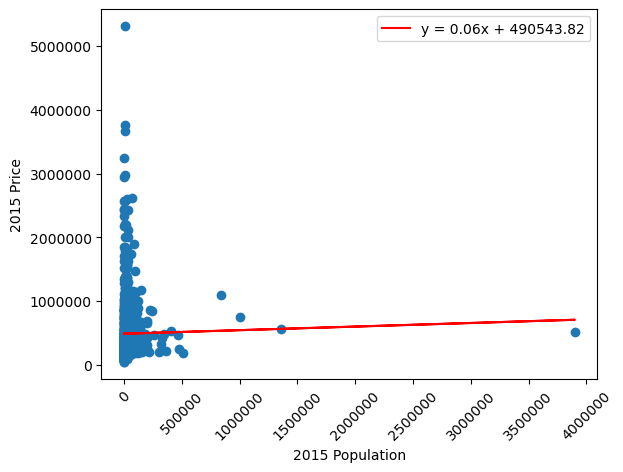

In [131]:
x_data = no_nulls_df['2015 Population']
y_data = no_nulls_df['2015 Price']
# x_data = remove_outliers(x_data)
# y_data = remove_outliers(y_data)
plot_linear_regression(x_data,y_data, "2015 Population","2015 Price")

The r-squared is: 0.0003006745874776821


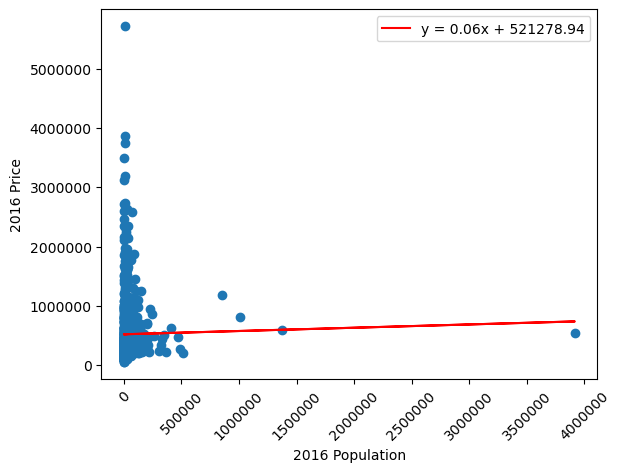

In [132]:
x_data = no_nulls_df['2016 Population']
y_data = no_nulls_df['2016 Price']

plot_linear_regression(x_data,y_data, "2016 Population","2016 Price")

The r-squared is: 0.00037771104765633236


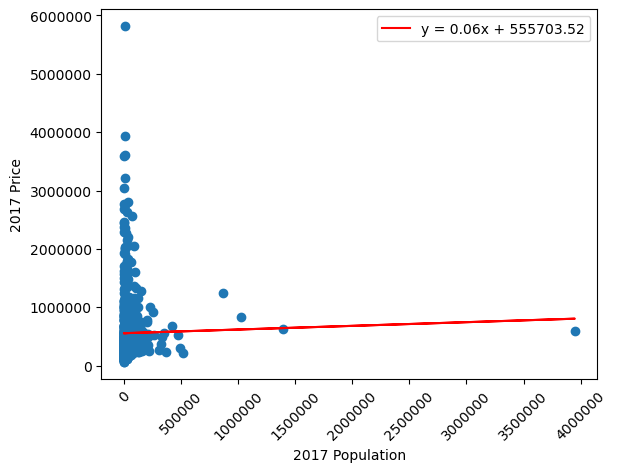

In [133]:
x_data = no_nulls_df['2017 Population']
y_data = no_nulls_df['2017 Price']

plot_linear_regression(x_data,y_data, "2017 Population","2017 Price")

The r-squared is: 0.0005576490869045826


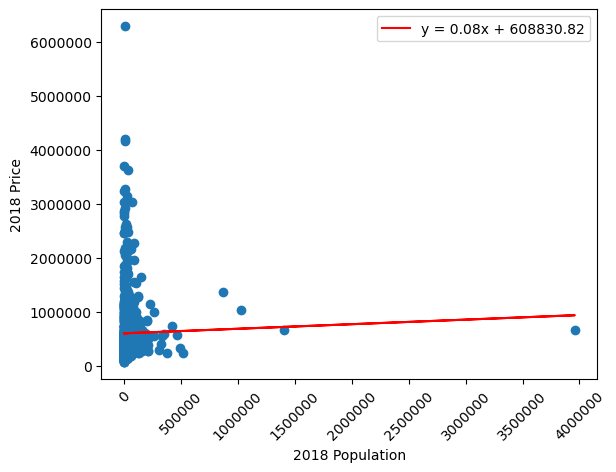

In [134]:
x_data = no_nulls_df['2018 Population']
y_data = no_nulls_df['2018 Price']

plot_linear_regression(x_data,y_data, "2018 Population","2018 Price")

The r-squared is: 0.0005502450367258076


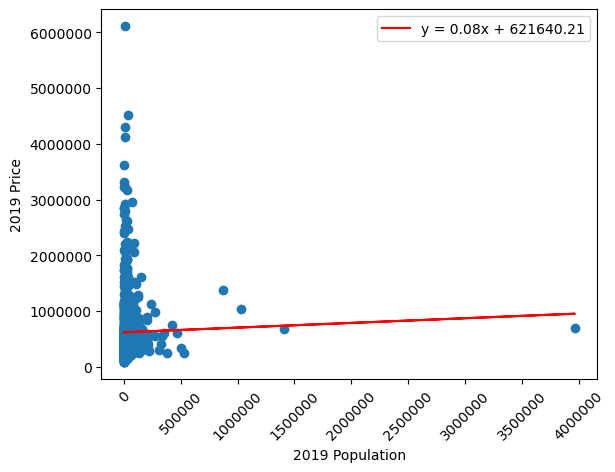

In [135]:
x_data = no_nulls_df['2019 Population']
y_data = no_nulls_df['2019 Price']

plot_linear_regression(x_data,y_data, "2019 Population","2019 Price")

The r-squared is: 0.0006563120659269197


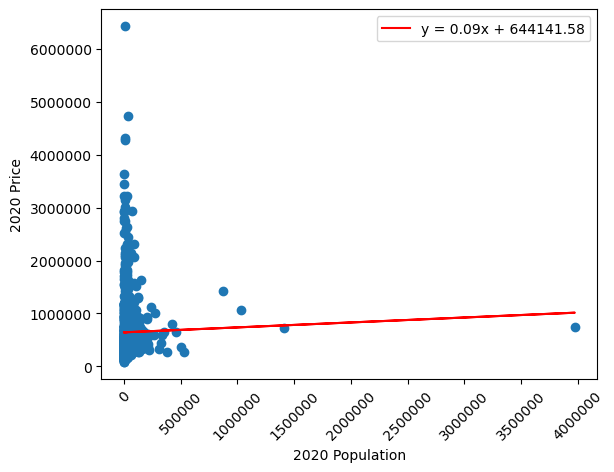

In [136]:
x_data = no_nulls_df['2020 Population']
y_data = no_nulls_df['2020 Price']

plot_linear_regression(x_data,y_data, "2020 Population","2020 Price")

The r-squared is: 0.0005187712770837582


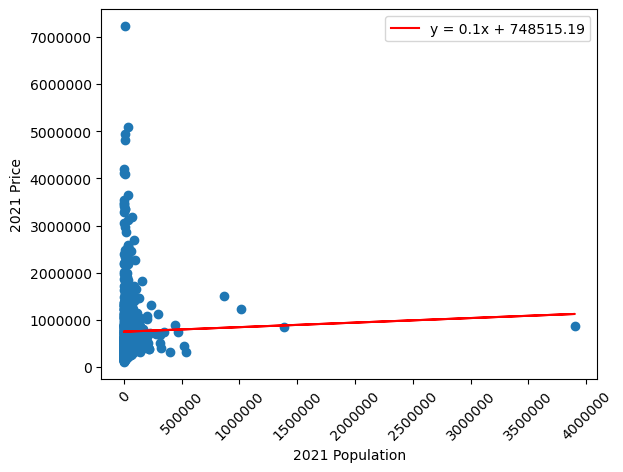

In [137]:
x_data = no_nulls_df['2021 Population']
y_data = no_nulls_df['2021 Price']

plot_linear_regression(x_data,y_data, "2021 Population","2021 Price")

In [138]:
for year in range(2016, 2022):
    previous_year = str(year - 1)
    current_year = str(year)
    
    # Calculate year-over-year change and add a new column for each year
    population_change = (
        ((no_nulls_df[current_year + ' Population'] - 
          no_nulls_df[previous_year + ' Population']) /
         no_nulls_df[previous_year + ' Population']) * 100)
    
    no_nulls_df.loc[:, current_year + ' Population Change (%)'] = population_change


for year in range(2016, 2022):
    previous_year = str(year - 1)
    current_year = str(year)
    
    # Calculate year-over-year change and add a new column for each year
    price_change = (
        ((no_nulls_df[current_year + ' Price'] - 
          no_nulls_df[previous_year + ' Price']) /
         no_nulls_df[previous_year + ' Price']) * 100)
    
    no_nulls_df.loc[:, current_year + ' Price Change (%)'] = price_change

no_nulls_df = no_nulls_df.dropna(how='any')
no_nulls_df

,City,2015 Population,2016 Population,2017 Population,2018 Population,2019 Population,2020 Population,2021 Population,2015 Price,2016 Price,...,2018 Population Change (%),2019 Population Change (%),2020 Population Change (%),2021 Population Change (%),2016 Price Change (%),2017 Price Change (%),2018 Price Change (%),2019 Price Change (%),2020 Price Change (%),2021 Price Change (%)
0,Acampo,787.0,466.0,520.0,294.0,204.0,261.0,263.0,411290.3,457113.1,...,-43.461538,-30.612245,27.941176,0.766284,11.141230,9.268319,10.004268,4.880561,0.289866,22.275471
1,Acton,7058.0,7170.0,7278.0,7185.0,7232.0,7054.0,6809.0,429758.9,449873.7,...,-1.277824,0.654141,-2.461283,-3.473207,4.680485,7.525579,10.981286,5.289811,4.720748,18.080885
2,Adelanto,32059.0,32311.0,32867.0,33416.0,33660.0,34238.0,37229.0,151547.4,163231.4,...,1.670368,0.730189,1.717172,8.735907,7.709799,13.731856,15.963761,6.770741,6.653575,22.614971
3,Adin,173.0,155.0,206.0,201.0,171.0,209.0,171.0,151136.3,163947.3,...,-2.427184,-14.925373,22.222222,-18.181818,8.476455,6.989807,6.224499,2.539969,1.342369,18.516659
4,Agoura Hills,20697.0,20689.0,20736.0,20636.0,20533.0,20269.0,20362.0,726644.3,729300.6,...,-0.482253,-0.499128,-1.285735,0.458829,0.365557,7.283622,8.606323,0.909530,4.702196,16.529740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,Yountville,2985.0,2991.0,2978.0,2982.0,2987.0,3001.0,3351.0,867632.5,930751.6,...,0.134318,0.167673,0.468698,11.662779,7.274866,5.924997,5.537567,3.628529,3.959933,17.027994
803,Yreka,7635.0,7598.0,7571.0,7551.0,7562.0,7589.0,7807.0,147052.4,155893.3,...,-0.264166,0.145676,0.357048,2.872579,6.012075,4.830355,7.041460,8.721558,4.149903,18.044156
804,Yuba City,66038.0,66147.0,66229.0,66388.0,66516.0,66660.0,69540.0,225099.8,243232.4,...,0.240076,0.192806,0.216489,4.320432,8.055360,11.242170,9.324776,4.975056,7.475647,17.816281
805,Yucaipa,52739.0,52886.0,53151.0,53264.0,53416.0,54358.0,54312.0,286070.9,302006.7,...,0.212602,0.285371,1.763517,-0.084624,5.570577,10.162324,11.037952,1.939226,5.438248,16.741075


In [139]:
#np.isinf(no_nulls_df['2016 Population Change (%)']).any()

test = no_nulls_df[no_nulls_df['2016 Population Change (%)'] == np.inf]
test

,City,2015 Population,2016 Population,2017 Population,2018 Population,2019 Population,2020 Population,2021 Population,2015 Price,2016 Price,...,2018 Population Change (%),2019 Population Change (%),2020 Population Change (%),2021 Population Change (%),2016 Price Change (%),2017 Price Change (%),2018 Price Change (%),2019 Price Change (%),2020 Price Change (%),2021 Price Change (%)


The r-squared is: 0.0003353807969485228


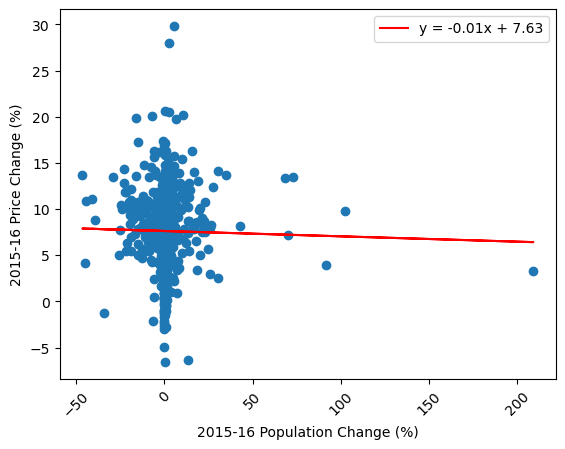

In [140]:
x_data = no_nulls_df['2016 Population Change (%)']
y_data = no_nulls_df['2016 Price Change (%)']

plot_linear_regression(x_data,y_data, "2015-16 Population Change (%)","2015-16 Price Change (%)")

The r-squared is: 0.0016097247100494685


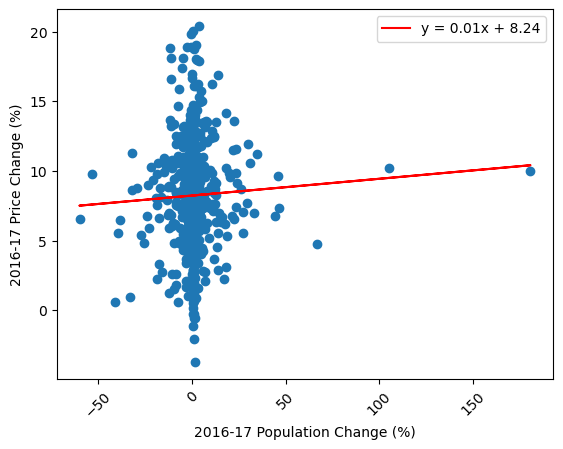

In [141]:
x_data = no_nulls_df['2017 Population Change (%)']
y_data = no_nulls_df['2017 Price Change (%)']

plot_linear_regression(x_data,y_data, "2016-17 Population Change (%)","2016-17 Price Change (%)")

The r-squared is: 0.00014234498336223908


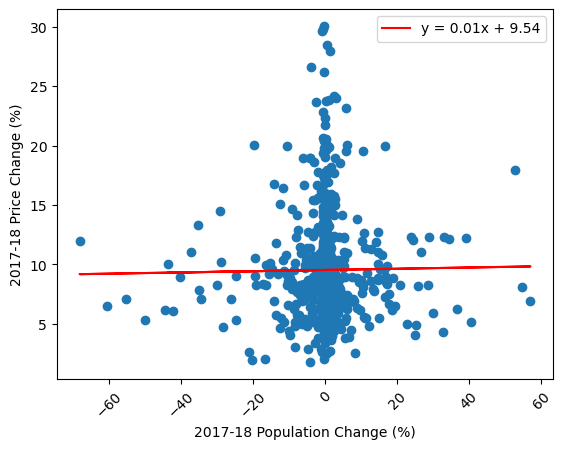

In [142]:
x_data = no_nulls_df['2018 Population Change (%)']
y_data = no_nulls_df['2018 Price Change (%)']

plot_linear_regression(x_data,y_data, "2017-18 Population Change (%)","2017-18 Price Change (%)")

The r-squared is: 0.00016296749313512632


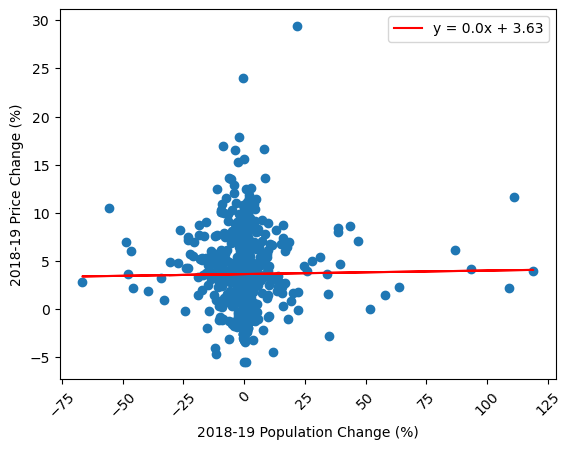

In [143]:
x_data = no_nulls_df['2019 Population Change (%)']
y_data = no_nulls_df['2019 Price Change (%)']

plot_linear_regression(x_data,y_data, "2018-19 Population Change (%)","2018-19 Price Change (%)")

The r-squared is: 0.0016135562226853091


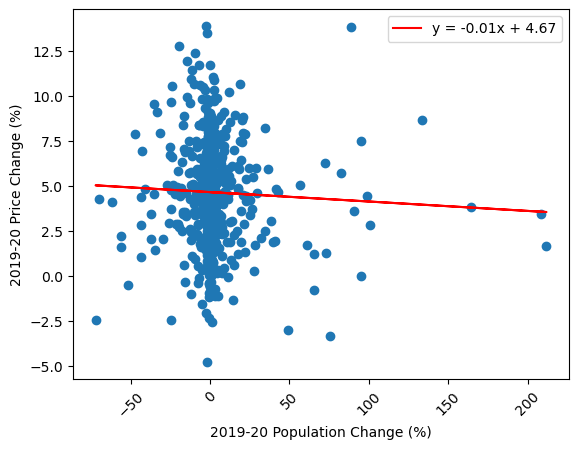

In [144]:
x_data = no_nulls_df['2020 Population Change (%)']
y_data = no_nulls_df['2020 Price Change (%)']

plot_linear_regression(x_data,y_data, "2019-20 Population Change (%)","2019-20 Price Change (%)")

In [145]:
#no_nulls_df['2020 Population Change (%)'].max()

In [146]:
#test = no_nulls_df[no_nulls_df['2020 Population Change (%)'] == 234627.2235418316]
#test

The r-squared is: 0.0050922009203388146


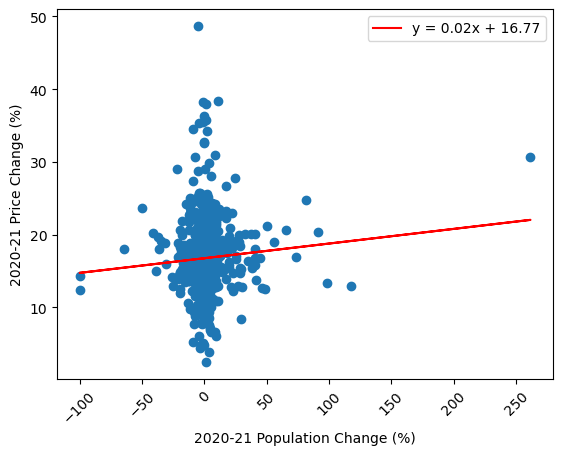

In [147]:
x_data = no_nulls_df['2021 Population Change (%)']
y_data = no_nulls_df['2021 Price Change (%)']

plot_linear_regression(x_data,y_data, "2020-21 Population Change (%)","2020-21 Price Change (%)")